## Imports

In [200]:
# Imports all of the libraries that will be utilized throughout this project
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime, timedelta
from io import StringIO
import requests

In [201]:
# Imports all of the scikit-Learn libraries that will be utilized throughout this project
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import r2_score

In [202]:
# Enables view of all columns when viewing Pandas DataFrames
pd.set_option('display.max_columns', None)

***

## Data Retrieval

In [203]:
# Private API Key utilized in the paramater variables below to extract data
api_key = '79f89dd4dffdddbddec2d92da0ca'

#### Round Scoring, Stats, & Strokes Gained - Training Dataset Retrieval

In [204]:
# Retrieves Training Data
api_url = "https://feeds.datagolf.com/historical-raw-data/rounds"

df_list = []

for year in range (2017, 2023):
    params = {
        'tour': 'pga',
        'event_id': 'all',
        'year': year,
        'file_format': 'csv',
        'key': api_key
    }

    response = requests.get(api_url, params=params)

    if response.status_code == 200:
        # Use StringIO to convert the response content into a file-like object for read_csv
        data = StringIO(response.text)
        df = pd.read_csv(data)
        df_list.append(df)
        print(f"Data added for year: {year}")
    else:
        print("Failed to fetch data from the API. Status code:", response.status_code)

tn_df = pd.concat(df_list, ignore_index=True)
train_df = tn_df.copy()

print("Train Data Retrieved!")

Data added for year: 2017
Data added for year: 2018
Data added for year: 2019
Data added for year: 2020
Data added for year: 2021
Data added for year: 2022
Train Data Retrieved!


#### Round Scoring, Stats, & Strokes Gained - Testing Dataset Retrieval

In [205]:
# Retrieves Testing Data
api_url = "https://feeds.datagolf.com/historical-raw-data/rounds"

df_list = []

for year in range (2023, 2025):
    params = {
        'tour': 'pga',
        'event_id': 'all',
        'year': year,
        'file_format': 'csv',
        'key': api_key
    }

    response = requests.get(api_url, params=params)

    if response.status_code == 200:
        # Use StringIO to convert the response content into a file-like object for read_csv
        data = StringIO(response.text)
        df = pd.read_csv(data)
        df_list.append(df)
        print(f"Data added for year: {year}")
    else:
        print("Failed to fetch data from the API. Status code:", response.status_code)

tt_df = pd.concat(df_list, ignore_index=True)
test_df = tt_df.copy()

print("Test Data Retrieved!")

Data added for year: 2023
Data added for year: 2024
Test Data Retrieved!


#### Player List & IDs Dataset Retrieval

In [206]:
# Retrieves Player Information Data
api_url = "https://feeds.datagolf.com/get-player-list"

params = {
    'file_format': 'csv',
    'key': api_key
}

response = requests.get(api_url, params=params)

if response.status_code == 200:
    # Use StringIO to convert the response content into a file-like object for read_csv
    data = StringIO(response.text)
    player_df = pd.read_csv(data)
    print("Player Data Retrieved!")
else:
    print("Failed to fetch data from the API. Status code:", response.status_code)

Player Data Retrieved!


#### Field Updates Dataset Retrieval

In [207]:
# Retrieves Player and Tournament Information Data for the Current Week
api_url = 'https://feeds.datagolf.com/field-updates'

params = {
    'tour': 'pga',
    'file_format': 'csv',
    'key': api_key
}

response = requests.get(api_url, params=params)

if response.status_code == 200:
    # Use StringIO to convert the response content into a file-like object for read_csv
    data = StringIO(response.text)
    field_df = pd.read_csv(data)
    print("Tournament Data Retrieved!")
else:
    print("Failed to fetch data from the API. Status code:", response.status_code)

Tournament Data Retrieved!


#### Player Rankings Dataset Retrieval

In [208]:
# Retrieves Player Rankings Data
api_url = 'https://feeds.datagolf.com/preds/get-dg-rankings'

params = {
    'file_format': 'csv',
    'key': api_key
}

response = requests.get(api_url, params=params)

if response.status_code == 200:
    # Use StringIO to convert the response content into a file-like object for read_csv
    data = StringIO(response.text)
    rank_df = pd.read_csv(data)
    print("Player Rankings Data Retrieved!")
else:
    print("Failed to fetch data from the API. Status code:", response.status_code)

Player Rankings Data Retrieved!


In [209]:
# Retrieves Total History Data
api_url = "https://feeds.datagolf.com/historical-raw-data/rounds"

df_list = []

for year in range (2017, 2025):
    params = {
        'tour': 'pga',
        'event_id': 'all',
        'year': year,
        'file_format': 'csv',
        'key': api_key
    }

    response = requests.get(api_url, params=params)

    if response.status_code == 200:
        # Use StringIO to convert the response content into a file-like object for read_csv
        data = StringIO(response.text)
        df = pd.read_csv(data)
        df_list.append(df)
        print(f"Data added for year: {year}")
    else:
        print("Failed to fetch data from the API. Status code:", response.status_code)

total_df = pd.concat(df_list, ignore_index=True)

print("Total History Data Retrieved!")

Data added for year: 2017
Data added for year: 2018
Data added for year: 2019
Data added for year: 2020
Data added for year: 2021
Data added for year: 2022
Data added for year: 2023
Data added for year: 2024
Total History Data Retrieved!


## Data Preprocessing

In [210]:
def initial_preprocessing(df):
    """
    
    Converts 'event_completed' to datetime, extracts numerical version of 'fin_text' column, converts 'teetime' into decimal form, 
    computes a 'round_completed' column, and extracts individual month and day number from the newly created 'round_completed' column.
    
    """
    df = df.dropna(axis=0)
    
    # Converts date from object to datetime
    df.loc[:, 'event_completed'] = df['event_completed'].astype('datetime64[ns]')
    df = df.copy()
    
    # Extracts the numerical portion of the finishing position information
    df['fin_num'] = df['fin_text'].str.extract('(\d+)')
    df.loc[df['fin_num'].isna(), 'fin_num'] = '0'
    df['fin_num'] = df['fin_num'].astype(int)
    df = df.drop(['fin_text'], axis=1)
    df = df.copy()
    
    # Converts times into a time format and then into a float, making the data compatible for input into our model
    df['teetime_cleaned'] = pd.to_datetime(df['teetime'], format='%I:%M%p').dt.time
    df['teetime_numeric'] = df['teetime_cleaned'].apply(lambda x: x.hour + x.minute / 60)
    df = df.drop(['teetime','teetime_cleaned'], axis=1)
    df = df.copy()
    
    # Computates the 'round completed' feature based off of the event completion date and round number
    def calculate_round_date(row):
        if row['round_num'] == 1:
            return row['event_completed'] - pd.Timedelta(days=3)
            df = df.copy()
        elif row['round_num'] == 2:
            return row['event_completed'] - pd.Timedelta(days=2)
            df = df.copy()
        elif row['round_num'] == 3:
            return row['event_completed'] - pd.Timedelta(days=1)
            df = df.copy()
        else:
            return row['event_completed']
            df = df.copy()
    df = df.copy()
    df['round_completed'] = df.apply(calculate_round_date, axis=1)
    df['month'] = df['round_completed'].dt.month
    df['day'] = df['round_completed'].dt.day
    df = df.copy()
    return df

In [211]:
# Creates new binary columns that indicate whether an individual won, finished in the top 5, 10, or 20, and whether they made the cut.
def add_performance_columns(df):
    """
    
    Creates new binary columns that indicate whether an individual won, finished in the top 5, 10, or 20, and whether they made the cut.
    
    """
    
    df['ohe_win'] = np.where(df['fin_num'] == 1, 1, 0)
    df['ohe_top_five'] = np.where(df['fin_num'] <= 5, 1, 0)
    df['ohe_top_ten'] = np.where(df['fin_num'] <= 10, 1, 0)
    df['ohe_top_twenty'] = np.where(df['fin_num'] <= 20, 1, 0)
    df['ohe_make_cut'] = np.where(df['fin_num'] != 0, 1, 0)
    df = df.copy()
    return df

In [212]:
# Creates moving statistics for all golfers
def calculate_golfer_statistics(df):
    """
    
    Creates moving statistics for all golfers.
    
    """
    
    
    df_sorted = df.sort_values(by=['year', 'dg_id','round_completed'], ascending=[True,True,True])
    statistics = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total', 'driving_dist', 'driving_acc', 'gir', 'scrambling', 'round_score']
    
    for stat in statistics:
        df_sorted[f'career_moving_avg_{stat}'] = df_sorted.groupby('dg_id')[stat].transform(lambda x: x.shift(1).expanding(min_periods=1).mean())
        df_sorted[f'career_moving_med_{stat}'] = df_sorted.groupby('dg_id')[stat].transform(lambda x: x.shift(1).expanding(min_periods=1).median())
        df_sorted = df_sorted.copy()
        
        for window in [44, 36, 28, 24, 20, 16, 12, 8, 4]:
            df_sorted[f'L{window}_moving_avg_{stat}'] = df_sorted.groupby('dg_id')[stat].transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).mean())
            df_sorted[f'L{window}_{stat}_std_dev'] = df_sorted.groupby('dg_id')[stat].transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).std())
            df_sorted = df_sorted.copy()
            
            if stat == 'round_score':
                df_sorted[f'L{window}_moving_min_{stat}'] = df_sorted.groupby('dg_id')[stat].transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).min())
                df_sorted[f'L{window}_moving_max_{stat}'] = df_sorted.groupby('dg_id')[stat].transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).max())
                df_sorted = df_sorted.copy()
                
        for window in [45, 37, 29, 21, 15, 11, 9, 7, 5]:
            df_sorted[f'L{window}_moving_med_{stat}'] = df_sorted.groupby('dg_id')[stat].transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).median())
            df_sorted = df_sorted.copy()
        
        if stat == 'round_score':
            df_sorted[f'career_min_{stat}'] = df_sorted.groupby('dg_id')[stat].transform(lambda x: x.shift(1).expanding(min_periods=1).min())
            df_sorted[f'career_max_{stat}'] = df_sorted.groupby('dg_id')[stat].transform(lambda x: x.shift(1).expanding(min_periods=1).max())
            df_sorted = df_sorted.copy()
    df_sorted = df_sorted.copy()
    return df_sorted

In [213]:
# Calculate days since each round and create binary columns to determine whether a golfer has played within the different specified timeframes
def add_time_since_flags(df, date_col):
    """
    
    Calculate days since each round and create binary columns to determine whether a golfer has played within the different specified timeframes.
    
    """
    
    df['Days_Since'] = df.groupby('dg_id')[date_col].diff().dt.days
    time_frames = [365, 180, 90, 60, 30, 10, 5]
    for days in time_frames:
        df[f'Last_{days}_Days'] = np.where(df['Days_Since'] <= days, 1, 0)
        df = df.copy()
    return df

In [15]:
# Lags the round statistics and score back one record so we can use the most recent record as a feature to predict the next round score
def add_lagged_features(df):
    """
    
    Lags the round statistics and score back one record so we can use the most recent record as a feature to predict the next round score.
    
    """
    
    columns_to_lag = [
        'year', 'season', 'event_id', 'round_num', 'course_num', 'course_par', 'start_hole', 
        'round_score', 'sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total', 
        'driving_dist', 'driving_acc', 'gir', 'scrambling', 'prox_rgh', 'prox_fw', 
        'great_shots', 'poor_shots', 'month', 'day', 'fin_num', 'teetime_numeric', 
        'ohe_win', 'ohe_top_five', 'ohe_top_ten', 'ohe_top_twenty', 'ohe_make_cut'
    ]
    for col in columns_to_lag:
        df[f'lagged_{col}'] = df.groupby('dg_id')[col].shift(1)
    df = df.dropna(axis=0)
    df = df.copy()

    return df

## Training Data

In [214]:
# Processes training data
train_df_sorted = initial_preprocessing(train_df)
train_df_sorted = add_performance_columns(train_df_sorted)
train_df_sorted = calculate_golfer_statistics(train_df_sorted)
train_df_sorted = add_time_since_flags(train_df_sorted,'round_completed')
train_df_sorted = add_lagged_features(train_df_sorted)

In [215]:
train_df_sorted.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 78270 entries, 179 to 104370
Data columns (total 416 columns):
 #    Column                          Dtype         
---   ------                          -----         
 0    tour                            object        
 1    year                            int64         
 2    season                          int64         
 3    event_completed                 object        
 4    event_name                      object        
 5    event_id                        int64         
 6    player_name                     object        
 7    dg_id                           int64         
 8    round_num                       int64         
 9    course_name                     object        
 10   course_num                      int64         
 11   course_par                      int64         
 12   start_hole                      int64         
 13   round_score                     int64         
 14   sg_putt                         float6

In [216]:
# Outputs the shape of our dataframe
print(f'There are {train_df_sorted.shape[0]} rows and {train_df_sorted.shape[1]} columns in the DataFrame.')

There are 78270 rows and 416 columns in the DataFrame.


## Testing Data

In [217]:
# Processes testing data
test_df_sorted = initial_preprocessing(test_df)
test_df_sorted = add_performance_columns(test_df_sorted)
test_df_sorted = calculate_golfer_statistics(test_df_sorted)
test_df_sorted = add_time_since_flags(test_df_sorted,'round_completed')
test_df_sorted = add_lagged_features(test_df_sorted)

In [218]:
test_df_sorted.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 18391 entries, 6034 to 24853
Data columns (total 416 columns):
 #    Column                          Dtype         
---   ------                          -----         
 0    tour                            object        
 1    year                            int64         
 2    season                          int64         
 3    event_completed                 object        
 4    event_name                      object        
 5    event_id                        int64         
 6    player_name                     object        
 7    dg_id                           int64         
 8    round_num                       int64         
 9    course_name                     object        
 10   course_num                      int64         
 11   course_par                      int64         
 12   start_hole                      int64         
 13   round_score                     float64       
 14   sg_putt                         float6

In [219]:
# Outputs the shape of our dataframe
print(f'There are {test_df_sorted.shape[0]} rows and {test_df_sorted.shape[1]} columns in the DataFrame.')

There are 18391 rows and 416 columns in the DataFrame.


## Total Data

In [220]:
# Processes total history dataframe
total_df_sorted = initial_preprocessing(total_df)
total_df_sorted = add_performance_columns(total_df_sorted)
total_df_sorted = calculate_golfer_statistics(total_df_sorted)
total_df_sorted = add_time_since_flags(total_df_sorted,'round_completed')
total_df_sorted = add_lagged_features(total_df_sorted)

In [221]:
# Outputs the shape of our dataframe
print(f'There are {total_df_sorted.shape[0]} rows and {total_df_sorted.shape[1]} columns in the DataFrame.')

There are 97698 rows and 416 columns in the DataFrame.


In [222]:
total_df[total_df['player_name']== 'Fowler, Rickie'].to_csv('total_df3.csv', index=False)

In [223]:
# Exports processed data for EDA and modeling in a separate notebook
test_df_sorted.to_csv('test_df_sorted.csv', index=False)
train_df_sorted.to_csv('train_df_sorted.csv', index=False)
field_df.to_csv('field_df.csv', index=False)
player_df.to_csv('player_df.csv', index=False)
rank_df[['player_name','country','owgr_rank']].to_csv('rank_df.csv', index=False)
total_df_sorted.to_csv('total_df_sorted.csv', index=False)

## EDA

In [224]:
# Creates correlation dataframe to analyze top coefficients
num_stat_df = train_df_sorted.copy()
num_stat_df = num_stat_df.drop(['tour','event_name','course_name','player_name','round_completed','event_completed','year'
                                        ,'season','event_completed','event_id','dg_id','round_num','course_num','course_par'
                                        ,'start_hole','sg_putt','sg_arg','sg_app','sg_ott','sg_t2g','sg_total','driving_dist'
                                        ,'driving_acc','gir','scrambling','prox_rgh','prox_fw','great_shots','poor_shots'
                                        ,'round_completed','month','day','fin_num','teetime_numeric','ohe_win','ohe_top_five'
                                        ,'ohe_top_ten','ohe_top_twenty','ohe_make_cut'], axis=1)
corr_df = num_stat_df.corr()

In [225]:
# Top 20 most correlated features with round score
top_positive = corr_df['round_score'].sort_values(ascending=False).head(11)
top_negative = corr_df['round_score'].sort_values(ascending=True).head(10)

In [226]:
top_positive.head(10)

round_score                   1.000000
L8_moving_avg_round_score     0.217667
L4_moving_avg_round_score     0.217434
L12_moving_avg_round_score    0.210861
L16_moving_avg_round_score    0.204422
lagged_round_score            0.200577
L7_moving_med_round_score     0.197602
L20_moving_avg_round_score    0.197532
L9_moving_med_round_score     0.197525
L5_moving_med_round_score     0.195655
Name: round_score, dtype: float64

In [227]:
top_negative.head(10)

lagged_ohe_make_cut       -0.229363
L4_moving_avg_gir         -0.200782
L8_moving_avg_gir         -0.193085
L5_moving_med_gir         -0.181249
L12_moving_avg_gir        -0.179733
L44_moving_avg_sg_total   -0.176429
L36_moving_avg_sg_total   -0.176129
L7_moving_med_gir         -0.175384
L28_moving_avg_sg_total   -0.174941
L24_moving_avg_sg_total   -0.172735
Name: round_score, dtype: float64

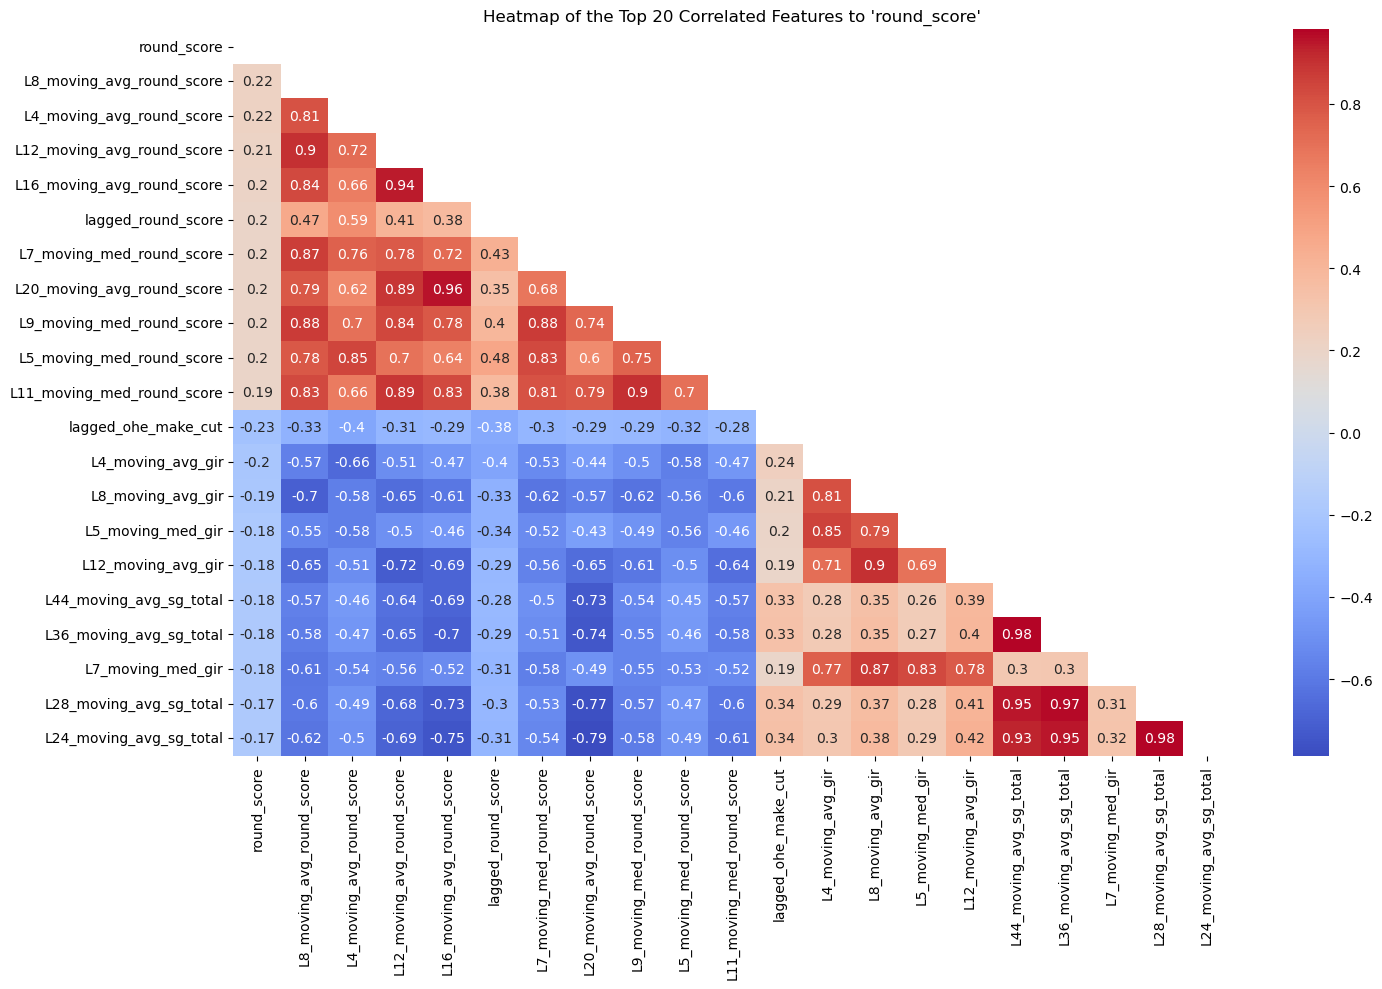

In [228]:
# Creates Seaborn heatmap
top_features = pd.Index(top_positive.index.tolist() + top_negative.index.tolist()).drop_duplicates()
filtered_corr_matrix = corr_df.loc[top_features, top_features]
mask = np.triu(filtered_corr_matrix)
plt.figure(figsize=(15,10))
sns.heatmap(filtered_corr_matrix, annot=True, cmap="coolwarm", mask=mask)
plt.title("Heatmap of the Top 20 Correlated Features to 'round_score'")
plt.tight_layout()
plt.savefig('Heatmap of the Top 20 Correlated Features.png')
plt.show()

## Modeling

### Linear Regression

In [229]:
# Copy test dataset for use later in the modeling process when we want to retrieve all players most recent round to feed to our model
current_df = test_df_sorted.copy()

In [230]:
# Drop the non-numeric and non-lagged columns prior to training our model
train_df_sorted = train_df_sorted.drop(['tour','event_name','course_name','player_name','round_completed','event_completed','year'
                                        ,'season','event_completed','event_id','dg_id','round_num','course_num','course_par'
                                        ,'start_hole','sg_putt','sg_arg','sg_app','sg_ott','sg_t2g','sg_total','driving_dist'
                                        ,'driving_acc','gir','scrambling','prox_rgh','prox_fw','great_shots','poor_shots'
                                        ,'round_completed','month','day','fin_num','teetime_numeric','ohe_win','ohe_top_five'
                                        ,'ohe_top_ten','ohe_top_twenty','ohe_make_cut'], axis=1)

test_df_sorted = test_df_sorted.drop(['tour','event_name','course_name','player_name','round_completed','event_completed','year'
                                        ,'season','event_completed','event_id','dg_id','round_num','course_num','course_par'
                                        ,'start_hole','sg_putt','sg_arg','sg_app','sg_ott','sg_t2g','sg_total','driving_dist'
                                        ,'driving_acc','gir','scrambling','prox_rgh','prox_fw','great_shots','poor_shots'
                                        ,'round_completed','month','day','fin_num','teetime_numeric','ohe_win','ohe_top_five'
                                        ,'ohe_top_ten','ohe_top_twenty','ohe_make_cut'], axis=1)

In [231]:
train_df_sorted.head()

,round_score,career_moving_avg_sg_putt,career_moving_med_sg_putt,L44_moving_avg_sg_putt,L44_sg_putt_std_dev,L36_moving_avg_sg_putt,L36_sg_putt_std_dev,L28_moving_avg_sg_putt,L28_sg_putt_std_dev,L24_moving_avg_sg_putt,L24_sg_putt_std_dev,L20_moving_avg_sg_putt,L20_sg_putt_std_dev,L16_moving_avg_sg_putt,L16_sg_putt_std_dev,L12_moving_avg_sg_putt,L12_sg_putt_std_dev,L8_moving_avg_sg_putt,L8_sg_putt_std_dev,L4_moving_avg_sg_putt,L4_sg_putt_std_dev,L45_moving_med_sg_putt,L37_moving_med_sg_putt,L29_moving_med_sg_putt,L21_moving_med_sg_putt,L15_moving_med_sg_putt,L11_moving_med_sg_putt,L9_moving_med_sg_putt,L7_moving_med_sg_putt,L5_moving_med_sg_putt,career_moving_avg_sg_arg,career_moving_med_sg_arg,L44_moving_avg_sg_arg,L44_sg_arg_std_dev,L36_moving_avg_sg_arg,L36_sg_arg_std_dev,L28_moving_avg_sg_arg,L28_sg_arg_std_dev,L24_moving_avg_sg_arg,L24_sg_arg_std_dev,L20_moving_avg_sg_arg,L20_sg_arg_std_dev,L16_moving_avg_sg_arg,L16_sg_arg_std_dev,L12_moving_avg_sg_arg,L12_sg_arg_std_dev,L8_moving_avg_sg_arg,L8_sg_arg_std_dev,L4_moving_avg_sg_arg,L4_sg_arg_std_dev,L45_moving_med_sg_arg,L37_moving_med_sg_arg,L29_moving_med_sg_arg,L21_moving_med_sg_arg,L15_moving_med_sg_arg,L11_moving_med_sg_arg,L9_moving_med_sg_arg,L7_moving_med_sg_arg,L5_moving_med_sg_arg,career_moving_avg_sg_app,career_moving_med_sg_app,L44_moving_avg_sg_app,L44_sg_app_std_dev,L36_moving_avg_sg_app,L36_sg_app_std_dev,L28_moving_avg_sg_app,L28_sg_app_std_dev,L24_moving_avg_sg_app,L24_sg_app_std_dev,L20_moving_avg_sg_app,L20_sg_app_std_dev,L16_moving_avg_sg_app,L16_sg_app_std_dev,L12_moving_avg_sg_app,L12_sg_app_std_dev,L8_moving_avg_sg_app,L8_sg_app_std_dev,L4_moving_avg_sg_app,L4_sg_app_std_dev,L45_moving_med_sg_app,L37_moving_med_sg_app,L29_moving_med_sg_app,L21_moving_med_sg_app,L15_moving_med_sg_app,L11_moving_med_sg_app,L9_moving_med_sg_app,L7_moving_med_sg_app,L5_moving_med_sg_app,career_moving_avg_sg_ott,career_moving_med_sg_ott,L44_moving_avg_sg_ott,L44_sg_ott_std_dev,L36_moving_avg_sg_ott,L36_sg_ott_std_dev,L28_moving_avg_sg_ott,L28_sg_ott_std_dev,L24_moving_avg_sg_ott,L24_sg_ott_std_dev,L20_moving_avg_sg_ott,L20_sg_ott_std_dev,L16_moving_avg_sg_ott,L16_sg_ott_std_dev,L12_moving_avg_sg_ott,L12_sg_ott_std_dev,L8_moving_avg_sg_ott,L8_sg_ott_std_dev,L4_moving_avg_sg_ott,L4_sg_ott_std_dev,L45_moving_med_sg_ott,L37_moving_med_sg_ott,L29_moving_med_sg_ott,L21_moving_med_sg_ott,L15_moving_med_sg_ott,L11_moving_med_sg_ott,L9_moving_med_sg_ott,L7_moving_med_sg_ott,L5_moving_med_sg_ott,career_moving_avg_sg_t2g,career_moving_med_sg_t2g,L44_moving_avg_sg_t2g,L44_sg_t2g_std_dev,L36_moving_avg_sg_t2g,L36_sg_t2g_std_dev,L28_moving_avg_sg_t2g,L28_sg_t2g_std_dev,L24_moving_avg_sg_t2g,L24_sg_t2g_std_dev,L20_moving_avg_sg_t2g,L20_sg_t2g_std_dev,L16_moving_avg_sg_t2g,L16_sg_t2g_std_dev,L12_moving_avg_sg_t2g,L12_sg_t2g_std_dev,L8_moving_avg_sg_t2g,L8_sg_t2g_std_dev,L4_moving_avg_sg_t2g,L4_sg_t2g_std_dev,L45_moving_med_sg_t2g,L37_moving_med_sg_t2g,L29_moving_med_sg_t2g,L21_moving_med_sg_t2g,L15_moving_med_sg_t2g,L11_moving_med_sg_t2g,L9_moving_med_sg_t2g,L7_moving_med_sg_t2g,L5_moving_med_sg_t2g,career_moving_avg_sg_total,career_moving_med_sg_total,L44_moving_avg_sg_total,L44_sg_total_std_dev,L36_moving_avg_sg_total,L36_sg_total_std_dev,L28_moving_avg_sg_total,L28_sg_total_std_dev,L24_moving_avg_sg_total,L24_sg_total_std_dev,L20_moving_avg_sg_total,L20_sg_total_std_dev,L16_moving_avg_sg_total,L16_sg_total_std_dev,L12_moving_avg_sg_total,L12_sg_total_std_dev,L8_moving_avg_sg_total,L8_sg_total_std_dev,L4_moving_avg_sg_total,L4_sg_total_std_dev,L45_moving_med_sg_total,L37_moving_med_sg_total,L29_moving_med_sg_total,L21_moving_med_sg_total,L15_moving_med_sg_total,L11_moving_med_sg_total,L9_moving_med_sg_total,L7_moving_med_sg_total,L5_moving_med_sg_total,career_moving_avg_driving_dist,career_moving_med_driving_dist,L44_moving_avg_driving_dist,L44_driving_dist_std_dev,L36_moving_avg_driving_dist,L36_driving_dist_std_dev,L28_moving_avg_driving_dist,L28_driving_dist_std_dev,L24_moving_avg_driv

In [232]:
# Seperates our features from our target variable
X_train = train_df_sorted.drop(['round_score'], axis=1)
y_train = train_df_sorted['round_score']

X_test = test_df_sorted.drop(['round_score'], axis=1)
y_test = test_df_sorted['round_score']

# Scales the data with a standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Instantiates our linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Scores the linear regression model with our scaled train and test data
r2_train = model.score(X_train_scaled,y_train)
r2_test = model.score(X_test_scaled,y_test)

# Caclulates the mean absolute percentage error so we have another metric to evaluate our model on
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
mape_train = mean_absolute_percentage_error(y_train_pred,y_train)
mape_test = mean_absolute_percentage_error(y_test_pred,y_test)

print(f' Train: \n r2: {r2_train:.4f} \n mape: {mape_train:.4f}')
print(f' Test: \n r2: {r2_test:.4f} \n mape: {mape_test:.4f}')

 Train: 
 r2: 0.2578 
 mape: 0.0310
 Test: 
 r2: 0.2600 
 mape: 0.0312


### Neural Network

In [35]:
# Seperates our features from our target variable
X_train = train_df_sorted.drop(['round_score'], axis=1)
y_train = train_df_sorted['round_score']

X_test = test_df_sorted.drop(['round_score'], axis=1)
y_test = test_df_sorted['round_score']

# Scales the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [138]:
# Instantiates Keras Neural Network
model = keras.Sequential()


# Creates a regularizer with a factor of 0.0001 and apply it to all hidden layers
# regularizer = keras.regularizers.l1(0.0001)

# Declares the hidden layers
model.add(layers.Dense(40, activation="relu"))#, kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(40, activation="relu"))#, kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(40, activation="relu"))#, kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1))

model.add(layers.Dense(40, activation="relu"))#, kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(40, activation="relu"))#, kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(40, activation="relu"))#, kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1))

model.add(layers.Dense(40, activation="relu"))#, kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(40, activation="relu"))#, kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(40, activation="relu"))#, kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1))


model.add(layers.Dense(40, activation="relu"))#, kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(40, activation="relu"))#, kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(40, activation="relu"))#, kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1))

model.add(layers.Dense(40, activation="relu"))#, kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(40, activation="relu"))#, kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(40, activation="relu"))#, kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1))

model.add(layers.Dense(40, activation="relu"))#, kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(40, activation="relu"))#, kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(40, activation="relu"))#, kernel_regularizer=regularizer))
model.add(layers.Dropout(0.1))


# Declares the output layer
model.add(layers.Dense(1))

# Compiles the model
optimizer = keras.optimizers.Adam()
loss=keras.losses.MeanSquaredError()

model.compile(optimizer=optimizer,
              loss=loss)

history = model.fit(X_train_scaled, y_train, epochs=200)

Epoch 1/200
2446/2446 [==============================] - 3s 1ms/step - loss: 204.6923
Epoch 2/200
2446/2446 [==============================] - 3s 1ms/step - loss: 49.4593
Epoch 3/200
2446/2446 [==============================] - 3s 1ms/step - loss: 40.3962
Epoch 4/200
2446/2446 [==============================] - 3s 1ms/step - loss: 35.0772
Epoch 5/200
2446/2446 [==============================] - 3s 1ms/step - loss: 32.1862
Epoch 6/200
2446/2446 [==============================] - 3s 1ms/step - loss: 30.0540
Epoch 7/200
2446/2446 [==============================] - 3s 1ms/step - loss: 28.7188
Epoch 8/200
2446/2446 [==============================] - 3s 1ms/step - loss: 27.4442
Epoch 9/200
2446/2446 [==============================] - 3s 1ms/step - loss: 26.8140
Epoch 10/200
2446/2446 [==============================] - 3s 1ms/step - loss: 25.8992
Epoch 11/200
2446/2446 [==============================] - 3s 1ms/step - loss: 25.0656
Epoch 12/200
2446/2446 [==============================] - 3s 1

In [139]:
# Evaluate the model using the test data and generate predictions
train_loss = history.history["loss"][-1]
result = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"Train Loss: {train_loss:.4f}")
print(f"Test Loss: {result:.4f}")

y_train_pred_nn = model.predict(X_train_scaled)
y_pred_nn = model.predict(X_test_scaled)

Train Loss: 6.6780
Test Loss: 7.5964


In [140]:
print(f'Train r2: {r2_score(y_train,y_train_pred_nn):.4f}')
print(f'Test r2: {r2_score(y_test,y_pred_nn):.4f}')

Train r2: 0.3728
Test r2: 0.2909


In [133]:
model.save('pga_nn_1')

INFO:tensorflow:Assets written to: pga_nn_1/assets


***

## Model Projections

In [141]:
# Retrieves every players most recent record
sorted_df = current_df.sort_values(by=['dg_id', 'round_completed'])
most_recent_scores = sorted_df.drop_duplicates(subset='dg_id', keep='last').reset_index(drop=True)

In [142]:
most_recent_scores[most_recent_scores['player_name']== 'Harman, Brian']

,tour,year,season,event_completed,event_name,event_id,player_name,dg_id,round_num,course_name,course_num,course_par,start_hole,round_score,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total,driving_dist,driving_acc,gir,scrambling,prox_rgh,prox_fw,great_shots,poor_shots,fin_num,teetime_numeric,round_completed,month,day,ohe_win,ohe_top_five,ohe_top_ten,ohe_top_twenty,ohe_make_cut,career_moving_avg_sg_putt,career_moving_med_sg_putt,L44_moving_avg_sg_putt,L44_sg_putt_std_dev,L36_moving_avg_sg_putt,L36_sg_putt_std_dev,L28_moving_avg_sg_putt,L28_sg_putt_std_dev,L24_moving_avg_sg_putt,L24_sg_putt_std_dev,L20_moving_avg_sg_putt,L20_sg_putt_std_dev,L16_moving_avg_sg_putt,L16_sg_putt_std_dev,L12_moving_avg_sg_putt,L12_sg_putt_std_dev,L8_moving_avg_sg_putt,L8_sg_putt_std_dev,L4_moving_avg_sg_putt,L4_sg_putt_std_dev,L45_moving_med_sg_putt,L37_moving_med_sg_putt,L29_moving_med_sg_putt,L21_moving_med_sg_putt,L15_moving_med_sg_putt,L11_moving_med_sg_putt,L9_moving_med_sg_putt,L7_moving_med_sg_putt,L5_moving_med_sg_putt,career_moving_avg_sg_arg,career_moving_med_sg_arg,L44_moving_avg_sg_arg,L44_sg_arg_std_dev,L36_moving_avg_sg_arg,L36_sg_arg_std_dev,L28_moving_avg_sg_arg,L28_sg_arg_std_dev,L24_moving_avg_sg_arg,L24_sg_arg_std_dev,L20_moving_avg_sg_arg,L20_sg_arg_std_dev,L16_moving_avg_sg_arg,L16_sg_arg_std_dev,L12_moving_avg_sg_arg,L12_sg_arg_std_dev,L8_moving_avg_sg_arg,L8_sg_arg_std_dev,L4_moving_avg_sg_arg,L4_sg_arg_std_dev,L45_moving_med_sg_arg,L37_moving_med_sg_arg,L29_moving_med_sg_arg,L21_moving_med_sg_arg,L15_moving_med_sg_arg,L11_moving_med_sg_arg,L9_moving_med_sg_arg,L7_moving_med_sg_arg,L5_moving_med_sg_arg,career_moving_avg_sg_app,career_moving_med_sg_app,L44_moving_avg_sg_app,L44_sg_app_std_dev,L36_moving_avg_sg_app,L36_sg_app_std_dev,L28_moving_avg_sg_app,L28_sg_app_std_dev,L24_moving_avg_sg_app,L24_sg_app_std_dev,L20_moving_avg_sg_app,L20_sg_app_std_dev,L16_moving_avg_sg_app,L16_sg_app_std_dev,L12_moving_avg_sg_app,L12_sg_app_std_dev,L8_moving_avg_sg_app,L8_sg_app_std_dev,L4_moving_avg_sg_app,L4_sg_app_std_dev,L45_moving_med_sg_app,L37_moving_med_sg_app,L29_moving_med_sg_app,L21_moving_med_sg_app,L15_moving_med_sg_app,L11_moving_med_sg_app,L9_moving_med_sg_app,L7_moving_med_sg_app,L5_moving_med_sg_app,career_moving_avg_sg_ott,career_moving_med_sg_ott,L44_moving_avg_sg_ott,L44_sg_ott_std_dev,L36_moving_avg_sg_ott,L36_sg_ott_std_dev,L28_moving_avg_sg_ott,L28_sg_ott_std_dev,L24_moving_avg_sg_ott,L24_sg_ott_std_dev,L20_moving_avg_sg_ott,L20_sg_ott_std_dev,L16_moving_avg_sg_ott,L16_sg_ott_std_dev,L12_moving_avg_sg_ott,L12_sg_ott_std_dev,L8_moving_avg_sg_ott,L8_sg_ott_std_dev,L4_moving_avg_sg_ott,L4_sg_ott_std_dev,L45_moving_med_sg_ott,L37_moving_med_sg_ott,L29_moving_med_sg_ott,L21_moving_med_sg_ott,L15_moving_med_sg_ott,L11_moving_med_sg_ott,L9_moving_med_sg_ott,L7_moving_med_sg_ott,L5_moving_med_sg_ott,career_moving_avg_sg_t2g,career_moving_med_sg_t2g,L44_moving_avg_sg_t2g,L44_sg_t2g_std_dev,L36_moving_avg_sg_t2g,L36_sg_t2g_std_dev,L28_moving_avg_sg_t2g,L28_sg_t2g_std_dev,L24_moving_avg_sg_t2g,L24_sg_t2g_std_dev,L20_moving_avg_sg_t2g,L20_sg_t2g_std_dev,L16_moving_avg_sg_t2g,L16_sg_t2g_std_dev,L12_moving_avg_sg_t2g,L12_sg_t2g_std_dev,L8_moving_avg_sg_t2g,L8_sg_t2g_std_dev,L4_moving_avg_sg_t2g,L4_sg_t2g_std_dev,L45_moving_med_sg_t2g,L37_moving_med_sg_t2g,L29_moving_med_sg_t2g,L21_moving_med_sg_t2g,L15_moving_med_sg_t2g,L11_moving_med_sg_t2g,L9_moving_med_sg_t2g,L7_moving_med_sg_t2g,L5_moving_med_sg_t2g,career_moving_avg_sg_total,career_moving_med_sg_total,L44_moving_avg_sg_total,L44_sg_total_std_dev,L36_moving_avg_sg_total,L36_sg_total_std_dev,L28_moving_avg_sg_total,L28_sg_total_std_dev,L24_moving_avg_sg_total,L24_sg_total_std_dev,L20_moving_avg_sg_total,L20_sg_total_std_dev,L16_moving_avg_sg_total,L16_sg_total_std_dev,L12_moving_avg_sg_total,L12_sg_total_std_dev,L8_moving_avg_sg_total,L8_sg_total_std_dev,L4_moving_avg_sg_total,L4_sg_total_std_dev,L45_moving_med_sg_total,L37_moving_med_sg_total,L29_moving_med_sg_total,L21_moving_med_sg_t

In [143]:
# Drops the necessary columns prior to feeding the dataframe into our model
most_recent_scores = most_recent_scores.drop(['tour','event_name','course_name','player_name','round_completed','event_completed','year'
                                        ,'season','event_completed','event_id','round_num','course_num','course_par'
                                        ,'start_hole','sg_putt','sg_arg','sg_app','sg_ott','sg_t2g','sg_total','driving_dist'
                                        ,'driving_acc','gir','scrambling','prox_rgh','prox_fw','great_shots','poor_shots'
                                        ,'round_completed','month','day','fin_num','teetime_numeric','ohe_win','ohe_top_five'
                                        ,'ohe_top_ten','ohe_top_twenty','ohe_make_cut'], axis=1)

# Removes player IDs before modelling
preserved_ids = most_recent_scores[['dg_id']].copy()
most_recent_scores = most_recent_scores.drop(['dg_id','round_score'], axis=1)

In [199]:
# Loops through predictions 4 times to simulate a full tournament and adds noise to output score to account for golfer variability day-to-day
sum_scores_df = preserved_ids.copy()
sum_scores_df['sum_predicted_score'] = 0

for i in range(1):
        mr_scaled = scaler.transform(most_recent_scores)
        predicted_score = model.predict(mr_scaled)
        noise = np.random.normal(0, 0, predicted_score.shape)

        predicted_score_noisy = predicted_score + noise
        predicted_score_noisy = predicted_score_noisy
        sum_scores_df['sum_predicted_score'] += predicted_score_noisy.flatten()

result_df = sum_scores_df.merge(player_df[['dg_id', 'player_name']], on='dg_id', how='left')
this_week_df = result_df.merge(field_df[['dg_id', 'event_name']], on='dg_id', how='inner')

this_week_df_sorted = this_week_df.sort_values(by='sum_predicted_score', ascending=True)
this_week_df_sorted.head(10)

,dg_id,sum_predicted_score,player_name,event_name
62,23604,67.135666,"Clark, Wyndham",Wells Fargo Championship
25,14139,67.235039,"Thomas, Justin",Wells Fargo Championship
4,8825,67.252693,"Harman, Brian",Wells Fargo Championship
8,10419,67.326019,"Noren, Alex",Wells Fargo Championship
61,23014,67.440842,"Theegala, Sahith",Wells Fargo Championship
34,15466,67.465652,"Cantlay, Patrick",Wells Fargo Championship
47,18103,67.488701,"Bezuidenhout, Christiaan",Wells Fargo Championship
28,14578,67.490974,"Henley, Russell",Wells Fargo Championship
35,15556,67.624809,"Hughes, Mackenzie",Wells Fargo Championship
40,17488,67.648087,"Im, Sungjae",Wells Fargo Championship


In [195]:
player_wins = pd.DataFrame({'dg_id': preserved_ids['dg_id'], 'wins': 0})
player_t5 = pd.DataFrame({'dg_id': preserved_ids['dg_id'], 'top_5': 0})
player_t10 = pd.DataFrame({'dg_id': preserved_ids['dg_id'], 'top_10': 0})
player_t20 = pd.DataFrame({'dg_id': preserved_ids['dg_id'], 'top_20': 0})

num_iterations = 2000
for iteration in range(num_iterations):
    sum_scores_df = preserved_ids.copy()
    sum_scores_df['sum_predicted_score'] = 0

    for i in range(4):
        mr_scaled = scaler.transform(most_recent_scores)
        predicted_score = model.predict(mr_scaled)
        noise = np.random.normal(0, 5, predicted_score.shape)

        predicted_score_noisy = predicted_score + noise
        sum_scores_df['sum_predicted_score'] += predicted_score_noisy.flatten()

    result_df = sum_scores_df.merge(player_df[['dg_id', 'player_name']], on='dg_id', how='left')
    this_week_df = result_df.merge(field_df[['dg_id', 'event_name']], on='dg_id', how='inner')

    this_week_df_sorted = this_week_df.sort_values(by='sum_predicted_score', ascending=True)

    lowest_score_dg_id = this_week_df_sorted.iloc[0]['dg_id']
    t5_dg_ids = this_week_df_sorted.iloc[:5]['dg_id'].values
    t10_dg_ids = this_week_df_sorted.iloc[:10]['dg_id'].values
    t20_dg_ids = this_week_df_sorted.iloc[:20]['dg_id'].values


    player_wins.loc[player_wins['dg_id'] == lowest_score_dg_id, 'wins'] += 1
    player_t5.loc[player_t5['dg_id'].isin(t5_dg_ids), 'top_5'] += 1
    player_t10.loc[player_t10['dg_id'].isin(t10_dg_ids), 'top_10'] += 1
    player_t20.loc[player_t20['dg_id'].isin(t20_dg_ids), 'top_20'] += 1


player_wins['win_probability'] = (player_wins['wins'] / num_iterations)*100
player_t5['t5_probability'] = (player_t5['top_5'] / num_iterations)*100
player_t10['t10_probability'] = (player_t10['top_10'] / num_iterations)*100
player_t20['t20_probability'] = (player_t20['top_20'] / num_iterations)*100

fin_df1 = player_wins.merge(this_week_df[['dg_id', 'player_name']], on='dg_id', how='inner').sort_values(by='wins', ascending=False)
fin_df2 = fin_df1.merge(player_t5, on='dg_id', how='left').sort_values(by=['wins','top_5'], ascending=[False,False])
fin_df3 = fin_df2.merge(player_t10, on='dg_id', how='left').sort_values(by=['wins','top_5','top_10'], ascending=[False,False,False])
fin_df4 = fin_df3.merge(player_t20, on='dg_id', how='left').sort_values(by=['wins','top_5','top_10','top_20'], ascending=[False,False,False,False])
final_fin_df = fin_df4[['dg_id','player_name','win_probability','t5_probability','t10_probability','t20_probability']].sort_values(by=['win_probability','t5_probability','t10_probability','t20_probability'], ascending=[False,False,False,False])

In [196]:
final_fin_df.head(40)

,dg_id,player_name,win_probability,t5_probability,t10_probability,t20_probability
0,8825,"Harman, Brian",6.45,22.55,38.20,62.65
1,23604,"Clark, Wyndham",6.40,24.15,40.80,65.50
2,14139,"Thomas, Justin",4.50,19.50,35.50,60.40
3,10419,"Noren, Alex",4.45,19.40,37.45,61.25
4,23014,"Theegala, Sahith",4.10,18.00,33.90,57.20
5,15466,"Cantlay, Patrick",4.05,18.75,33.10,56.50
6,14578,"Henley, Russell",3.95,17.95,33.35,57.80
7,15556,"Hughes, Mackenzie",3.85,16.50,31.65,55.05
8,16283,"Rodgers, Patrick",3.80,16.50,30.35,54.35
9,17488,"Im, Sungjae",3.80,16.40,30.35,54.35
